  #      Neural Network From Scratch API.
by : Balkis Bouthaina DIRAHOUI

# Imports

In [248]:

from google.colab import drive
drive.mount('/gdrive')
import sys
sys.path.append('/gdrive/MyDrive/Sorbonne/ML/projet/tools/')
import mltools as tl
import numpy as np
import matplotlib.pyplot as plt
from mltools import *
import copy
import numpy as np
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.datasets import mnist
import seaborn as sns
plt.style.use('seaborn-whitegrid')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#Classe Module 

In [249]:
class Module(object):
    def __init__(self):
        self._parameters = None
        self._gradient = None

    def zero_grad(self):
        # Annul gradient
        pass

    def forward(self, X):
        # Calculi la passe forward
        pass

    def update_parameters(self, gradient_step=1e-3):
        self._parameters -= gradient_step * self._gradient

    def backward_update_gradient(self, input, delta):
        # Met a jour la value du gradient
        pass

    def backward_delta(self, input, delta):
        # Calculate la derivee de l'erreur
        pass 


# Classe Linéaire

In [250]:
class Linear(Module):

    def __init__(self, n, d, biais=True, type=2):
        
        self._n = n
        self._d = d
        self._gradient = np.zeros((n, d))
        self._parameters = params(n,d,type)
        #si on veut rajouter le biais 
        if biais:
            self._biais=biais_params(n,d,type)
            self._grad_biais = np.zeros((1, d))
        else:
            self._biais = None

   
    def forward(self, X):
   
        assert X.shape[1] == self._n  # batch * input

        if self._biais is not None:
            return np.dot(X, self._parameters) + self._biais  # batch * out
        else:
            return np.dot(X, self._parameters)  # batch * out

    def backward_update_gradient(self, input, delta):
        #met a jour les gradients
        """
        :param input: batch * input
        :param delta:batch * out
          :return: batch*input
        """
        assert input.shape[1] == self._n
        assert delta.shape[1] == self._d
        assert input.shape[0] == delta.shape[0]

        self._gradient += np.dot(input.T, delta)

        if self._biais is not None:
            self._grad_biais += np.sum(delta, axis=0)

    def update_parameters(self, gradient_step=1e-3):
      #met a jour les parametres
        self._parameters -= gradient_step * self._gradient

        if self._biais is not None:
            self._biais -= gradient_step * self._grad_biais

    def backward_delta(self, input, delta):
      #compute delta
        assert input.shape[1] == self._n
        assert delta.shape[1] == self._d

        return np.dot(delta, self._parameters.T)

    def zero_grad(self):
      #met le gradient a zero 
        self._gradient = np.zeros((self._n, self._d))
        self.grad_biais= np.zeros((1, self._d))


# Loss

In [251]:
class Loss(object):
    
    def forward(self, y, yhat):
        pass

    def backward(self, y, yhat):
        pass
class MSELoss(Loss):
    
    def forward(self, y, yhat):
        #params passé en entrée sont de la bonne taille
        assert(y.shape == yhat.shape)
        return np.sum((y - yhat) ** 2,axis = 1)
    
    def backward(self, y, yhat):
        #params passé en entrée sont de la bonne taille
        assert(y.shape == yhat.shape)
        # derivée par rapport a yhat
        return -2*(y - yhat) 

class CELoss(Loss):
    
    def forward(self, y, yhat):
        #params passé en entrée sont de la bonne taille
        assert(y.shape == yhat.shape)
        return 1 - np.sum(yhat * y, axis = 1)
    
    def backward(self, y, yhat):
        #params passé en entrée sont de la bonne taille 
        assert(y.shape == yhat.shape)  
        return yhat-y
    
class BCELoss(Loss):
    
    def forward(self, y, yhat):
        #params passé en entrée sont de la bonne taille
        assert(y.shape == yhat.shape)
        return - (y*np.log(yhat + 1e-4) + (1-y)*np.log(1-yhat+ 1e-4))
    
    def backward(self, y, yhat):
        #params passé en entrée sont de la bonne taille
        assert(y.shape == yhat.shape)
        return ((1-y)/(1-yhat+ 1e-4)) - (y/yhat+ 1e-4)
    
    
class CElogSoftMax(Loss):
    
    def forward(self, y, yhat):
        #params passé en entrée sont de la bonne taille
        assert(y.shape == yhat.shape)
        return np.log(np.sum(np.exp(yhat), axis=1)+ 1e-4) - np.sum(y * yhat,axis = 1)

    def backward(self, y, yhat):
        #params passé en entrée sont de la bonne taille
        assert(y.shape == yhat.shape)
        e = np.exp(yhat)
        return e / np.sum(e, axis=1).reshape((-1,1)) - y


#Class non lineaire

In [252]:

class TanH(Module):

    def forward(self, X):
        return np.tanh(X)

    def backward_delta(self, input, delta):
        return (1 - np.tanh(input) ** 2) * delta

    def update_parameters(self, gradient_step=1e-3):
        pass


class Sigmoid(Module):

    def forward(self, X):
        return 1 / (1 + np.exp(-X))

    def backward_delta(self, input, delta):
        #derivée pour la backprop chain rule 
        outh = 1 / (1 + np.exp(-input))
        return delta * (outh * (1 - outh))

    def update_parameters(self, gradient_step=1e-3):
        pass


class Softmax(Module):

    def forward(self, X):
        #pass forward 
        e = np.exp(X)
        return e / np.sum(e, axis=1).reshape((-1, 1))

    def backward_delta(self, input, delta):
        #backward, pour la propagation
        e = np.exp(input)
        outh = e/ np.sum(e, axis=1).reshape((-1, 1))
        return delta * (outh * (1 - outh))

    def update_parameters(self, gradient_step=1e-3):
        pass


class ReLU(Module):
    def __init__(self,threshold=0.):
     
        self._threshold=threshold

    def update_parameters(self, gradient_step=1e-3):
        pass

    def forward(self, X):
        self._forward=self.threshold(X)
        return self._forward

    def threshold(self,input):
        return np.where(input>self._threshold,input,0.)


    def derivative_Threshold(self,input):
        #Batch x out
        #np.where(self.threshold(input)<=self._threshold,0.,1.)
        return (input > self._threshold).astype(float)

    def backward_delta(self, input, delta):
        self._delta=np.multiply(delta,self.derivative_Threshold(input))
        return self._delta


# Class sequentiel



In [276]:
 

class Sequentiel:
    
    def __init__(self, modules,labels=None):
        #s'assurer qu'il ya assez de module (plus que 1)
        assert(len(modules) > 0)
        self._modules = modules
        self._labels = labels

    def forward(self, x):
        foward_list = [x]
        #ajouter des modules en serie
        for module in self._modules:
            foward_list.append(module.forward(foward_list[-1]))
        foward_list.reverse()
        return foward_list
        

    def backward(self, s, delta):
        #backward 
        list_ = [delta]
        for i, module in enumerate(np.flip(self._modules)):
            module.backward_update_gradient(s[i+1], list_[-1])
            list_.append(module.backward_delta(s[i+1] , list_[-1]))
        return list_
    
    def update_parameters(self, eps = 1e-3):
        for module in self._modules:
            module.update_parameters(gradient_step=eps)
            module.zero_grad()

            
    
    def predict(self, x):
        if self._labels is not None:
            return self._labels(self.forward(x)[0])
        return self.forward(x)[0]
    

class Optim:
    
    def __init__(self, net, loss, eps = 1e-3):
        self._net  = net
        self._loss = loss
        self._eps  = eps
    # step(batch_x,batch_y) qui calcule la sortie du réseau 
    #sur batch_x, calcule le coût par rapport aux labels batch_y,
    def step(self,batch_x, batch_y):
        
        s = self._net.forward(batch_x)
        loss = self._loss.forward(batch_y,s[0])
        delta = self._loss.backward(batch_y, s[0])
        self._net.backward(s, delta)
        self._net.update_parameters(self._eps)
        
        return loss
   
    def SGD(self, X,y, batch_size, epochs=10,es=500):
        n = len(X)
        len_y = len(y)
        assert n == len_y
        
        i = np.random.permutation(len(X))
        X = X[i]
        y = y[i]
    
        batch_in  = [X[i:i + batch_size] for i in range(0, n, batch_size)]
        batch_y = [y[i:i + batch_size] for i in range(0, len_y, batch_size)]
       
        hist_mean = []
        hist_std = []

        loss_min=float("inf")
        best_ep = 0
        st=0


        best_net = self._net

        for epoch in range(epochs):
            l = []
            for x,y in zip(batch_in, batch_y):
                l.append(np.asarray(self.step(x, y)).mean())
            l = np.asarray(l)
            loss = l.mean()
            st+=1
            if(loss < loss_min):
                st=0
                best_ep = epoch
                loss_min = loss
                best_net = copy.deepcopy(self._net)
            if st == es:
                break
            hist_mean.append(loss)
            hist_std.append(l.std())
          
        self._net = best_net
        return hist_mean, hist_std
                
    def score(self,x,y):
        return np.where(y == self._net.predict(x),1,0).mean()

# Convolutions

## Conv1D

In [258]:
class Conv1D(Module):

    def __init__(self, k_size, chan_in, chan_out, stride=1, bias=True):
        """
        k_size : kernel size
        chan_in : number of channels (in)
        chan_out : number of channels (in)

        """
        super(Conv1D, self).__init__()
        self.k_size=k_size
        self.chan_in=chan_in
        self.chan_out=chan_out
        self.stride=stride
        b=1 / np.sqrt(chan_in*k_size)
        self._parameters = np.random.uniform(-b, b, (k_size,chan_in,chan_out))
        self._gradient=np.zeros(self._parameters.shape)
        self.bias = bias
        if(self.bias):
            self._bias=np.random.uniform(-b, b, chan_out)
            self._gradBias = np.zeros((chan_out))

    def zero_grad(self):
       
        self._gradient=np.zeros(self._gradient.shape)
        if (self.bias):
            self._gradBias = np.zeros(self._gradBias.shape)

    def forward(self, X):
        """
       
        X: (batch,input,chan_in)
        out: (batch, (input-k_size)/stride +1,chan_out)
        """
        size = ((X.shape[1] - self.k_size) // self.stride) + 1

        out=np.array([(X[:, i: i + self.k_size, :].reshape(X.shape[0], -1)) @ (self._parameters.reshape(-1, self.chan_out))
                         for i in range(0,size,self.stride)])
        if (self.bias):
            out+=self._bias
        self._forward=out.transpose(1,0,2)
        return self._forward

    def update_parameters(self, gradient_step=1e-3):
       
        self._parameters -= gradient_step * self._gradient
        if self.bias:
            self._bias -= gradient_step * self._gradBias

    def backward_update_gradient(self, input, delta):
        """
        input: (batch,input,chan_in)
        delta: (batch, (input-k_size)/stride +1,chan_out)
       
        """
        size = ((input.shape[1] - self.k_size) // self.stride) + 1
        out = np.array([ (delta[:,i,:].T) @ (input[:, i: i + self.k_size, :].reshape(input.shape[0], -1))  \
                           for i in range(0, size, self.stride)])
        self._gradient=np.sum(out,axis=0).T.reshape(self._gradient.shape)/delta.shape[0]

        if self.bias:
            self._gradBias=delta.mean((0,1))

    def backward_delta(self, input, delta):
        """
        input: (batch,input,chan_in)
        delta: (batch, (input-k_size)/stride +1,chan_out)
        out: (batch,input,chan_in)
        """
        size = ((input.shape[1] - self.k_size) // self.stride) + 1
        out = np.zeros(input.shape)
        for i in range(0, size, self.stride):
            out[:,i:i+self.k_size,:] += ((delta[:, i, :]) @ (self._parameters.reshape(-1,self.chan_out).T)).reshape(input.shape[0],self.k_size,self.chan_in)
        self._delta= out
        return self._delta
#maxpool
class MaxPool1D(Module):

    def __init__(self, k_size=3, stride=1):
        super(MaxPool1D, self).__init__()
        self.k_size = k_size
        self.stride = stride

    def forward(self, X):
        """
        X: (batch,input,chan_in)
        out:  (batch,(input-k_size)/stride +1,chan_in)
        """

        size = ((X.shape[1] - self.k_size) // self.stride) + 1
        out = np.zeros((X.shape[0], size, X.shape[2]))
        for i in range(0, size, self.stride):
            out[:,i,:]=np.max(X[:,i:i+self.k_size,:],axis=1)
        self._forward=out
        return self._forward

    def update_parameters(self, gradient_step=1e-3):
        pass

    def backward_delta(self, input, delta):
        """
         input: (batch,input,chan_in)
         delta: (batch,(input-k_size)/stride +1,chan_in)
         out: (batch,input,chan_in)
        """
        size = ((input.shape[1] - self.k_size) // self.stride) + 1
        out=np.zeros(input.shape)
        batch=input.shape[0]
        chan_in=input.shape[2]
        for i in range(0,size,self.stride):
            indexes_argmax = np.argmax(input[:, i:i+self.k_size,:], axis=1) + i
            out[np.repeat(range(batch),chan_in),indexes_argmax.flatten(),list(range(chan_in))*batch]=delta[:,i,:].reshape(-1)
        self._delta=out
        return self._delta
class Flatten(Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, X):
        """
        X:(batch,input,chan_in)
        out:(batch,input*chan_in)
        """
        self._forward = X.reshape(X.shape[0], -1)
        return self._forward

    def update_parameters(self, gradient_step=1e-3):
        pass

    def backward_delta(self, input, delta):
        """
         input: (batch,input,chan_in)
         delta: (batch, input * chan_in)
         out: (batch,input,chan_in)
        """
        self._delta = delta.reshape(input.shape)
        return self._delta


## Conv2D

In [260]:
class Conv2D(Module):

    def __init__(self, k_size, chan_in, chan_out, stride=1, bias=True):
     
        super(Conv2D, self).__init__()
        self.k_size=k_size
        self.chan_in=chan_in
        self.chan_out=chan_out
        self.stride=stride
        b=1 / np.sqrt(chan_in*k_size)
        
        self._parameters = np.random.uniform(-b, b, (k_size,k_size,chan_in,chan_out))
        self._gradient=np.zeros(self._parameters.shape)
        self.bias = bias
        if(self.bias):
            self._bias=np.random.uniform(-b, b, chan_out)
            self._gradBias = np.zeros((chan_out))

    def zero_grad(self):

        self._gradient = np.zeros(self._gradient.shape)
        if (self.bias):
            self._gradBias = np.zeros(self._gradBias.shape)

    def forward(self, X):
        """
         X:(batch, H, W, chan_in)
         out:(batch,size_H,size_W,chan_out)
        """

        size_h = ((X.shape[1] - self.k_size) // self.stride) + 1
        size_w = ((X.shape[2] - self.k_size) // self.stride) + 1
        out=np.zeros((X.shape[0],size_h,size_w,self.chan_out))

        for i in range(0,size_h,self.stride):
            for j in range(0,size_w,self.stride):
                out[:,i,j,:]=X[:,i: i + self.k_size,j: j + self.k_size,:].shape(X.shape[0],-1) @ self._parameters.shape(-1,self.chan_out)
        if (self.bias):
            out += self._bias
        self._forward = out
        return self._forward

    def update_parameters(self, gradient_step=1e-3):
       
        self._parameters -= gradient_step * self._gradient
        if self.bias:
            self._bias -= gradient_step * self._gradBias

    def backward_update_gradient(self, input, delta):
      
        size_h = ((input.shape[1] - self.k_size) // self.stride) + 1
        size_w = ((input.shape[2] - self.k_size) // self.stride) + 1
        out=np.zeros(self._gradient.shape)
        for i in range(0, size_h, self.stride):
            for j in range(0, size_w, self.stride):
                    s=(delta[:, i,j, :].T) @ (input[:, i: i + self.k_size,j: j + self.k_size, :].shape(input.shape[0], -1))
                    out+=s.shape(s.shape[0],self.k_size,self.k_size,input.shape[-1]).transpose(1,2,3,0)
        self._gradient=out/delta.shape[0]
        if self.bias:
            self._gradBias=delta.mean((0,1,2))

    def backward_delta(self, input, delta):
        size_h = ((input.shape[1] - self.k_size) // self.stride) + 1
        size_w = ((input.shape[2] - self.k_size) // self.stride) + 1
        out = np.zeros(input.shape)
        for i in range(0, size_h, self.stride):
            for j in range(0, size_w, self.stride):
                s=(delta[:,i,j,:])@(self._parameters.shape(-1,self.chan_out).T)
               
                out[:, i:i + self.k_size, j:j + self.k_size, :]+=s.shape(delta.shape[0],self.k_size,self.k_size,self.chan_in)
                
        self._delta=out
        return self._delta


In [261]:

class MaxPool2D(Module):

    def __init__(self, k_size=3, stride=1):
        super(MaxPool2D, self).__init__()
        self.k_size = k_size
        self.stride = stride

    def forward(self, X):
        """
        X: (batch,Hlength,Wlength,chan_in)
        out :  (batch,t_h,t_w,chan_in)
        """
        t_h = ((X.shape[1] - self.k_size) // self.stride) + 1
        t_w = ((X.shape[2] - self.k_size) // self.stride) + 1
        sortie=np.zeros((X.shape[0],t_h,t_w,X.shape[-1]))
        for i in range(0, t_h, self.stride):
            for j in range(0, t_w, self.stride):
                sortie[:, i,j, :] = np.max(X[:,i:i+self.k_size, j:j + self.k_size, :], axis=(1,2))
        self._forward=sortie
        return self._forward

    def update_parameters(self, gradient_step=1e-3):
        pass

    def backward_delta(self, input, delta):
        t_h = ((input.shape[1] - self.k_size) // self.stride) + 1
        t_w = ((input.shape[2] - self.k_size) // self.stride) + 1
        batch=input.shape[0]
        chan_in=input.shape[3]
        sortie=np.zeros((input.shape[0],input.shape[1]*input.shape[2],input.shape[3]))
        for i in range(0, t_h, self.stride):
            for j in range(0, t_w, self.stride):
                region_shaped=input[:, i:i+self.k_size,j:j+self.k_size,:].reshape(-1,self.k_size*self.k_size,chan_in)
                idx_argmax=np.argmax(region_shaped, axis=1) + i + j
                sortie[np.repeat(range(batch),chan_in),idx_argmax.flatten(),list(range(chan_in))*batch]=delta[:,i,j,:].reshape(-1)
        self._delta=sortie.reshape(input.shape)
        return self._delta

# Tests Lineaire

###A Test vs Sickit learn

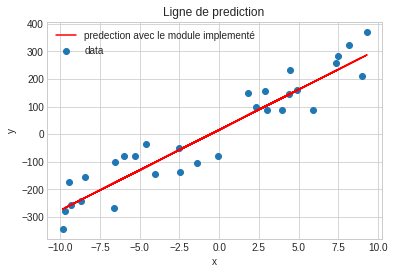

Text(0.5, 1.0, 'Ligne de prediction sickit-learn')

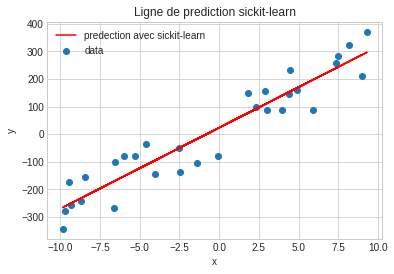

In [262]:
#generer un dataset

def generate_dataset_simple(alpha, beta):
  x= np.random.uniform(-10,10,alpha).reshape((-1,1))
  e= (np.random.uniform(-100,100,alpha)).reshape((-1,1))  
  y = alpha * x + beta + e 
  return x,y

x, y = generate_dataset_simple(30, 10)
#gradient descent
loss_mse = MSELoss()
couche_lin = Linear(x.shape[1], 1,type=1)

hist_loss = []
for _ in range(100):
    #forward
    couche_Linear = couche_lin.forward(x)
    #backward
    hist_loss.append(loss_mse.forward(y, couche_Linear).mean())
    
    loss_back = loss_mse.backward(y, couche_Linear)
    delta_linear = couche_lin.backward_delta(x, loss_back)
    
    couche_lin.backward_update_gradient(x, loss_back)
    couche_lin.update_parameters(gradient_step=1e-4)
    
    couche_lin.zero_grad()

pred = couche_lin.forward(x)
plt.figure()
plt.scatter(x,y,label="data",cmap='viridis')
plt.plot(x,pred,color='red',label='predection avec le module implementé')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ligne de prediction ")
plt.show()
#sickit
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x, y)
pred_sickit = model.predict(x)

plt.figure()
plt.scatter(x,y,label="data",cmap='viridis')
plt.plot(x,pred_sickit,color='red',label='predection avec sickit-learn')

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ligne de prediction sickit-learn")





### B : evolution de la mse selon les iterations

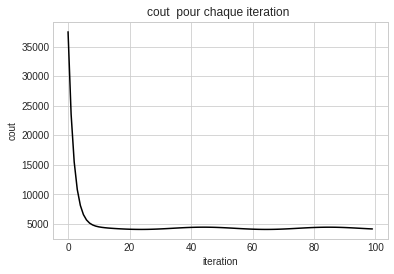

In [263]:

plt.figure()
plt.plot(np.arange(100),hist_loss,color="black")
plt.title("cout  pour chaque iteration ")
plt.xlabel("iteration")
plt.ylabel("cout")
plt.show()

###C: classification lineaire

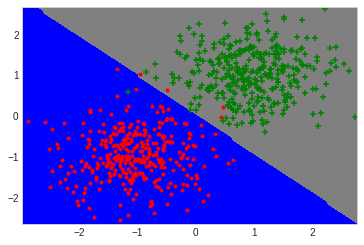

In [268]:
size = 690

datax, datay = gen_arti(centerx=1, centery=1, sigma=0.4, nbex=size, data_type=0, epsilon=0.1)
testx, testy = gen_arti(centerx=1, centery=1, sigma=0.4, nbex=size, data_type=0, epsilon=0.1)

datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))


n = datax.shape[1]
d = 1



iteration = 100

loss_mse = MSELoss()
couche_lin = Linear(n, d,type=0)

for _ in range(100):
    #forward
    couche_cach = couche_lin.forward(datax)
    #backward
    mse_ = loss_mse.backward(datay, couche_cach)
    delta_linear = couche_lin.backward_delta(datax, mse_)

    couche_lin.backward_update_gradient(datax, mse_)
    couche_lin.update_parameters(gradient_step=1e-3)
    couche_lin.zero_grad()


def predict(x):

    return np.where(couche_lin.forward(x) >= 0.5,1, 0)


acc = np.where(testy == predict(testx),1,0).mean()
#print("accuracy : ",acc)
plt.figure()
plot_frontiere(testx, predict, step=100)
plot_data(testx, testy.reshape(-1))
#plt.title("accuracy = "+str(acc))
plt.show()

# Tests Non lineaire

accuracy :  0.993


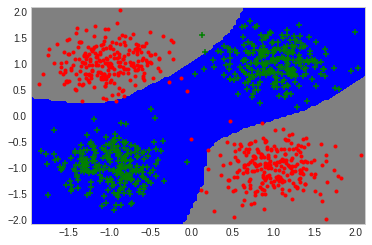

In [284]:


size =1000

datax, datay = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)
testx, testy = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)


datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))



couche_linn = Linear( datax.shape[1], 60,type=0)
couche_lin2 = Linear(80, 1,type=0)
layer_sig = Sigmoid()
layer_tan = TanH()

for _ in range(100):
    
    #forward
    hidden_lin = couche_lin.forward(datax)   
    hidden_tan = layer_tan.forward(hidden_lin)
    
    hidden_lin2 = couche_lin2.forward(hidden_tan)
    hidden_sig = layer_sig.forward(hidden_lin2)
    loss = loss_mse.forward(datay,hidden_sig)
    
    #backward
    
    loss_back = loss_mse.backward(datay, hidden_sig)
    delta_sig = layer_sig.backward_delta(hidden_lin2,loss_back)
    delta_lin2 = couche_lin2.backward_delta(hidden_tan,delta_sig)
    delta_tan = layer_tan.backward_delta(hidden_lin,delta_lin2)
    delta_lin = couche_lin.backward_delta(datax,delta_tan)
    


    couche_lin2.backward_update_gradient(hidden_tan, delta_sig)
    couche_lin.backward_update_gradient(datax, delta_tan)    
    

    couche_lin2.update_parameters(gradient_step = 1e-4)
    couche_lin.update_parameters(gradient_step = 1e-4)
    
    couche_lin2.zero_grad()
    couche_lin.zero_grad()
    


def predict(x):
    hidden_l = couche_lin.forward(x)
    hidden_l = layer_tan.forward(hidden_l)
    hidden_l = couche_lin2.forward(hidden_l)
    hidden_l = layer_sig.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

print("accuracy : ",np.where(testy == predict(testx),1,0).mean())

plot_frontiere(testx, predict, step=100)
plot_data(testx, testy.reshape(-1))


# Test Encapsulage (Sequential)

### Test module sequentiel

### D1 : Variation des couches

accuracy :  0.8153333333333334


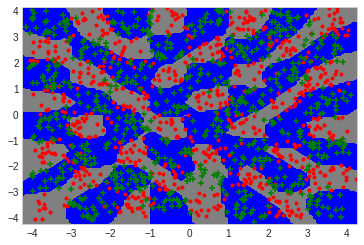

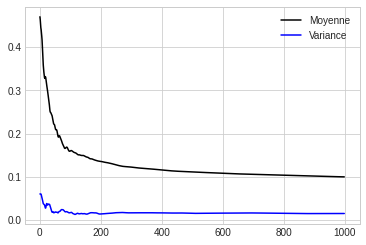

In [285]:
size = 1500

datax, datay = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=2, epsilon=0.1)
testx, testy = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=2, epsilon=0.1)


datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))



nh = 80
nh2 = 60

def pred(x):
    return np.where(x >= 0.5,1, 0)

    
loss_mse = MSELoss()
couche_lin = Linear( datax.shape[1], nh,type=1)
couche_lin2 = Linear(nh, nh2,type=1)
couche_lin3 = Linear(nh2, 1,type=1)

sig = Sigmoid()
tan = TanH()

net = Sequentiel([couche_lin,tan,couche_lin2,tan,couche_lin3,sig],labels=pred)

opt = Optim(net,loss_mse,eps=1e-4)
sizeba = 100
mean, std = opt.SGD(datax,datay,sizeba,1000)

print("accuracy : ",opt.score(testx,testy))

plot_frontiere(testx, opt._net.predict, step=100)
plot_data(testx, testy.reshape(-1))
plt.figure()
plt.plot(mean,'black')
plt.plot(std,'blue')
plt.legend(('Moyenne', 'Variance'))
plt.show()

accuracy :  0.9973333333333333


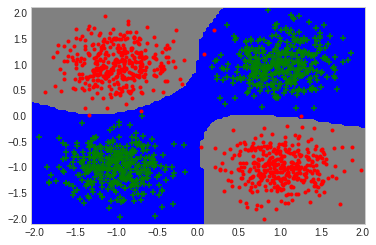

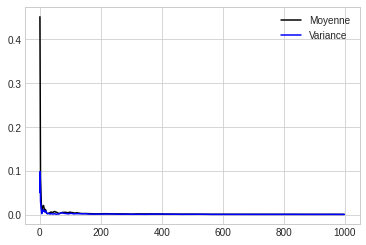

In [286]:
size = 1500

datax, datay = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)
testx, testy = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)


datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))



nh = 80
nh2 = 60

def pred(x):
    return np.where(x >= 0.5,1, 0)

    
loss_mse = MSELoss()
couche_lin = Linear( datax.shape[1], nh,type=1)
couche_lin2 = Linear(nh, nh2,type=1)
couche_lin3 = Linear(nh2, 1,type=1)

sig = Sigmoid()
tan = TanH()

net = Sequentiel([couche_lin,tan,couche_lin2,tan,couche_lin3,sig],labels=pred)

opt = Optim(net,loss_mse,eps=1e-4)
sizeba = 100
mean, std = opt.SGD(datax,datay,sizeba,1000)

print("accuracy : ",opt.score(testx,testy))

plot_frontiere(testx, opt._net.predict, step=100)
plot_data(testx, testy.reshape(-1))
plt.figure()
plt.plot(mean,'black')
plt.plot(std,'blue')
plt.legend(('Moyenne', 'Variance'))
plt.show()

# Test Multi Classe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


accuracy :  0.83


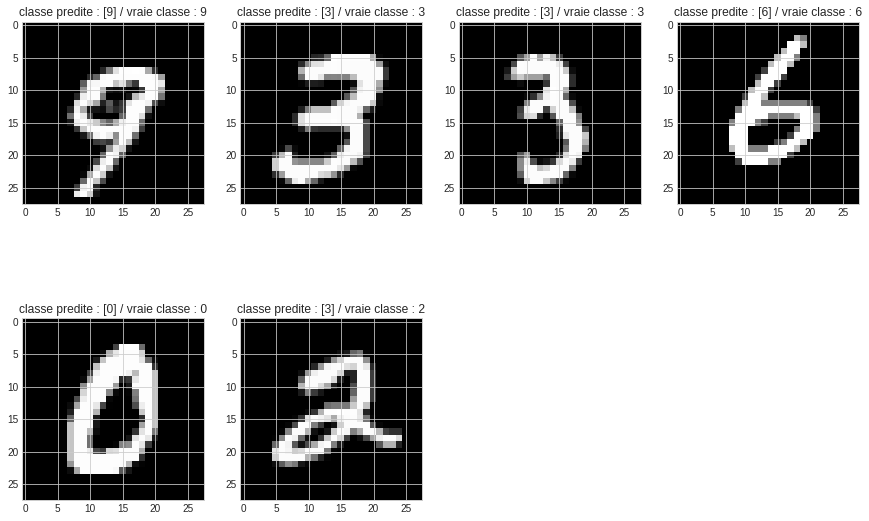

In [290]:
from keras.datasets import mnist

# données

def encod_onehot(y):
   onehot = np.zeros((10))
   onehot[y]=1
   return list(onehot)



def my_train_test_split(n_train,n_test):
    d =784
    trs = 60000
    trt = 10000

          
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

 
    X_train = X_train.reshape(trs, d)
    X_test = X_test.reshape(trt, d)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

 
    X_train /= 255
    X_test /= 255


    X_train = X_train[:n_train]
    y_train = y_train[:n_train]
    X_test = X_train[:n_test]
    y_test = y_train[:n_test]
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = my_train_test_split(5000,100)
y_train = np.asarray([encod_onehot(x) for x in y_train])



def pred(x):
    #retourner la meuilleur classe
    return np.argmax(x,axis=1)

couche_lin = Linear(X_train.shape[1], 128,type=2)
couche_lin2 = Linear(128, 64,type=2)
couche_lin3 = Linear(64, 10,type=2)
softmax = Softmax()
tan = TanH()
loss = CElogSoftMax()



net = Sequentiel([couche_lin,tan,couche_lin2,tan,couche_lin3,softmax],labels=pred)


modele = Optim(net,loss,eps=1e-2)

modele.SGD(X_train,y_train,100,1500,es=60)


print("accuracy : ",modele.score(X_test,y_test))

tl.plot_img(X_test,y_test,modele._net,6,n=28)



In [ ]:
d = dict()
list_eps = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]
d[1e-1]= 0.69
d[1e-2]= 0.82
d[1e-3]= 0.73
d[1e-4]= 0.75
d[1e-5]= 0.48
d[1e-6]= 0.4
d[1e-7] = 0.29
d[1e-8]= 0.19
d[1e-9]= 0.16
d[1e-10]=0.08

# Test auto encodeur

In [291]:
# données

def encod_onehot(y):
   onehot = np.zeros((10))
   onehot[y]=1
   return list(onehot)

def my_train_test_split(n_train,n_test):
    d =784
    trs = 60000
    trt = 10000

          
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

 
    X_train = X_train.reshape(trs, d)
    X_test = X_test.reshape(trt, d)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

 
    X_train /= 255
    X_test /= 255


    X_train = X_train[:n_train]
    y_train = y_train[:n_train]
    X_test = X_train[:n_test]
    y_test = y_train[:n_test]
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = my_train_test_split(5000,100)
y_train = np.asarray([encod_onehot(x) for x in y_train])



### Test Compression 

In [292]:
def plot_rec(X_test,net,nbp=None,n=28,n_comp=4):
    
    if  nbp == None:
        #echantillon contenant tous les chiffres 
        ids = [1,3,5,7,2,0,18,15,17,4]
        nbp=10
    else:
        ids = np.random.choice(np.arange(X_test.shape[0]), nbp, replace=False)
    plt.figure(figsize=(5*nbp,15))
    j = 1
    for i in ids:
        plt.subplot(3,nbp,j)
        show_image(X_test[i],n)

        plt.subplot(3,nbp,j+nbp)
        show_image(net.predict(np.asarray([X_test[i]])),n)
        
        j+=1

done


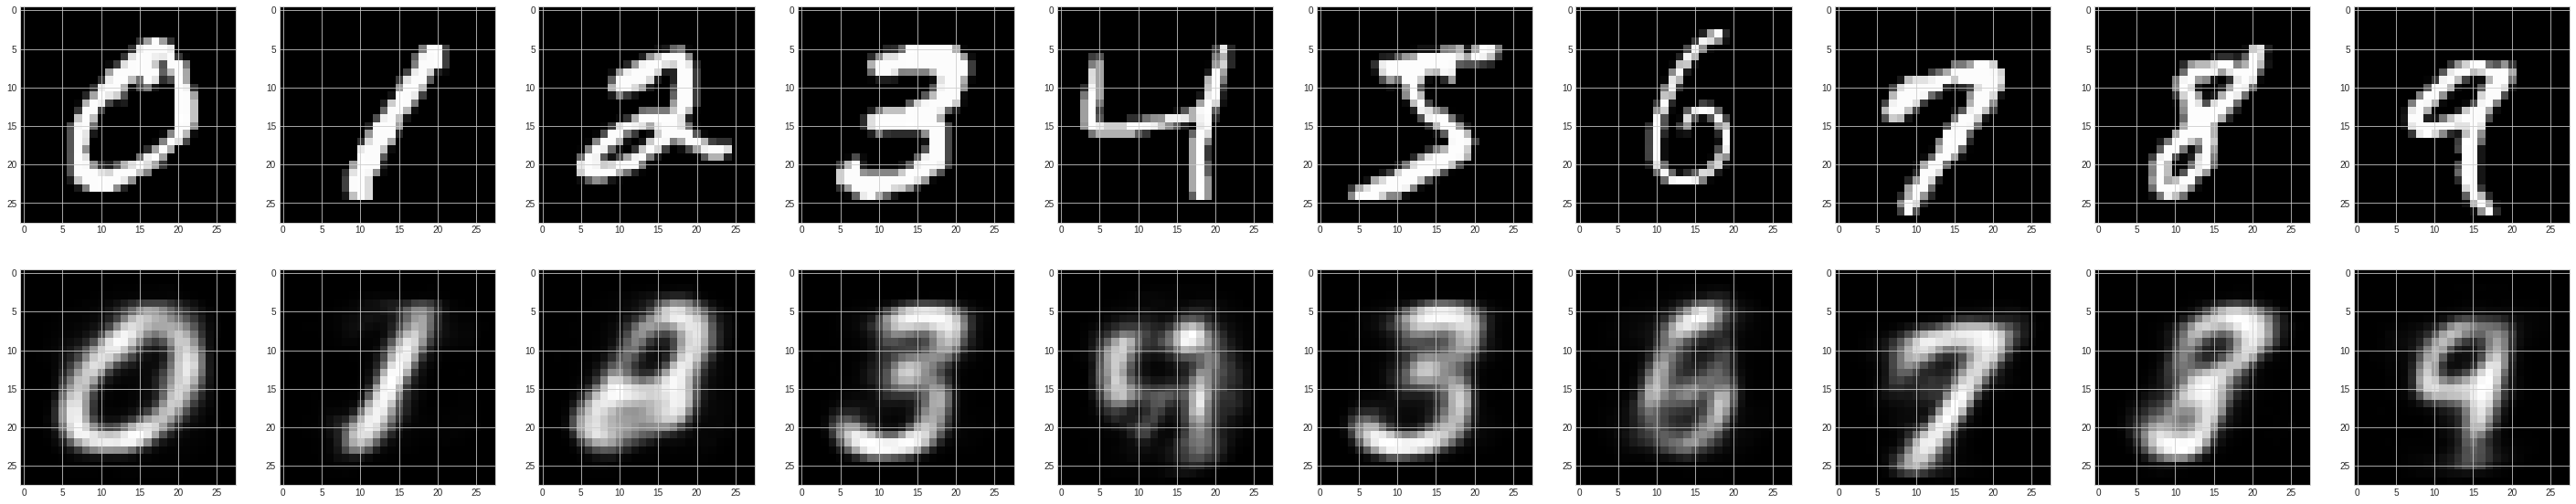

In [294]:




couche_lin = Linear(X_train.shape[1], 100)
couche_lin2 = Linear(100, 144)
couche_lin3 = Linear(144, 100)
couche_lin3._parameters = couche_lin2._parameters.T
couche_lin4 = Linear(100, X_train.shape[1])
couche_lin4._parameters = couche_lin._parameters.T

#cross entropie binaire comme cout 
loss = BCELoss()
#notre encodeur et decodeur
Encodeur = [couche_lin,TanH(),couche_lin2,TanH()]
Decodeur = [couche_lin3,TanH(),couche_lin4,Sigmoid()]
#le reseau
reseau = Sequentiel(Encodeur + Decodeur)

so = Optim(reseau,loss,eps=1e-4)
so.SGD(X_train,X_train,100,100,es=50)

print("done")

plot_rec(X_test,so._net)



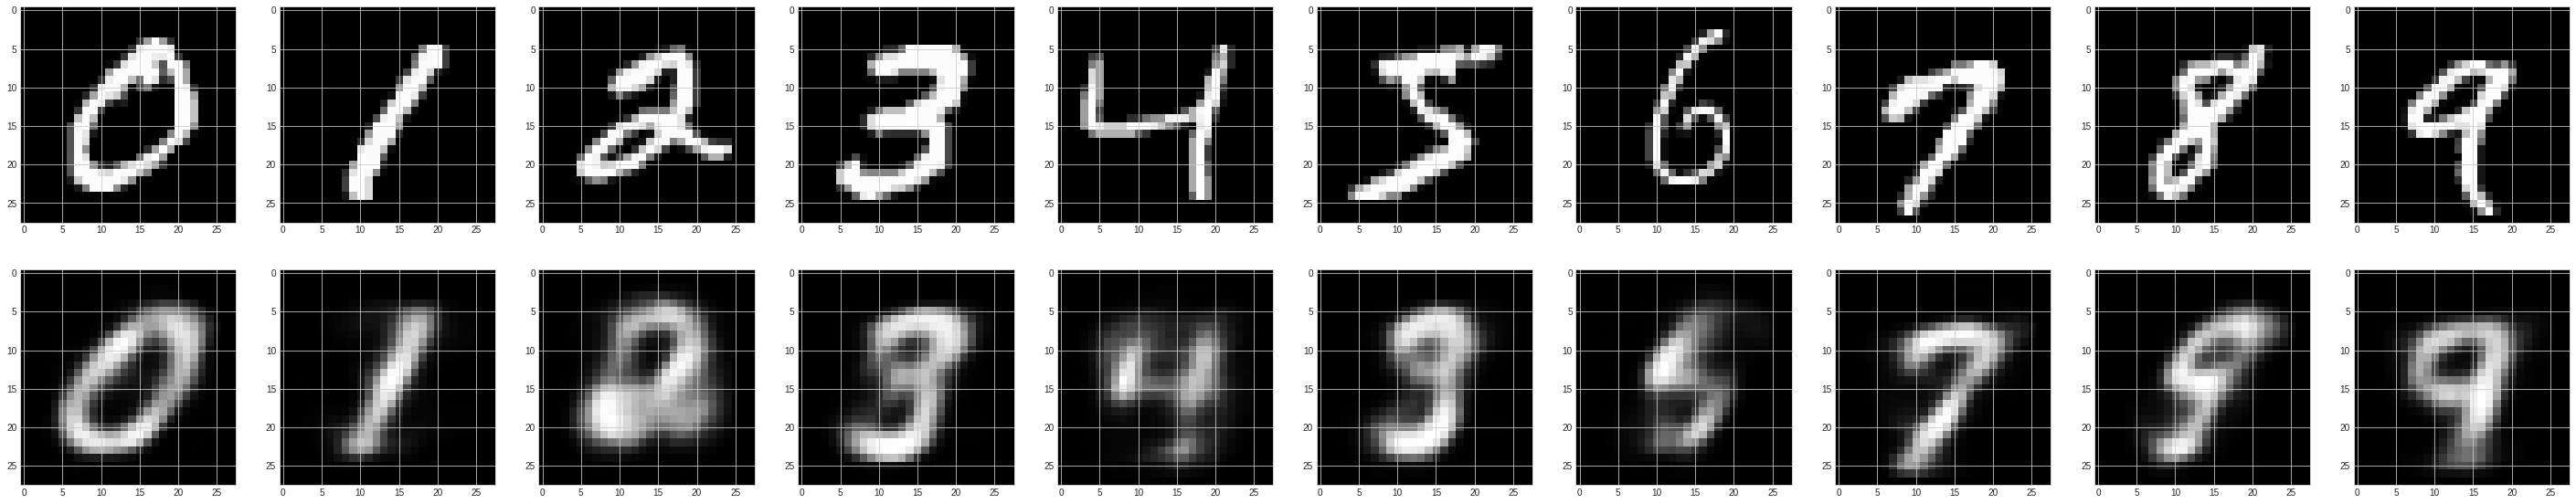

In [ ]:
plot_rec(X_test,so._net)


### Debruitage des images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


done


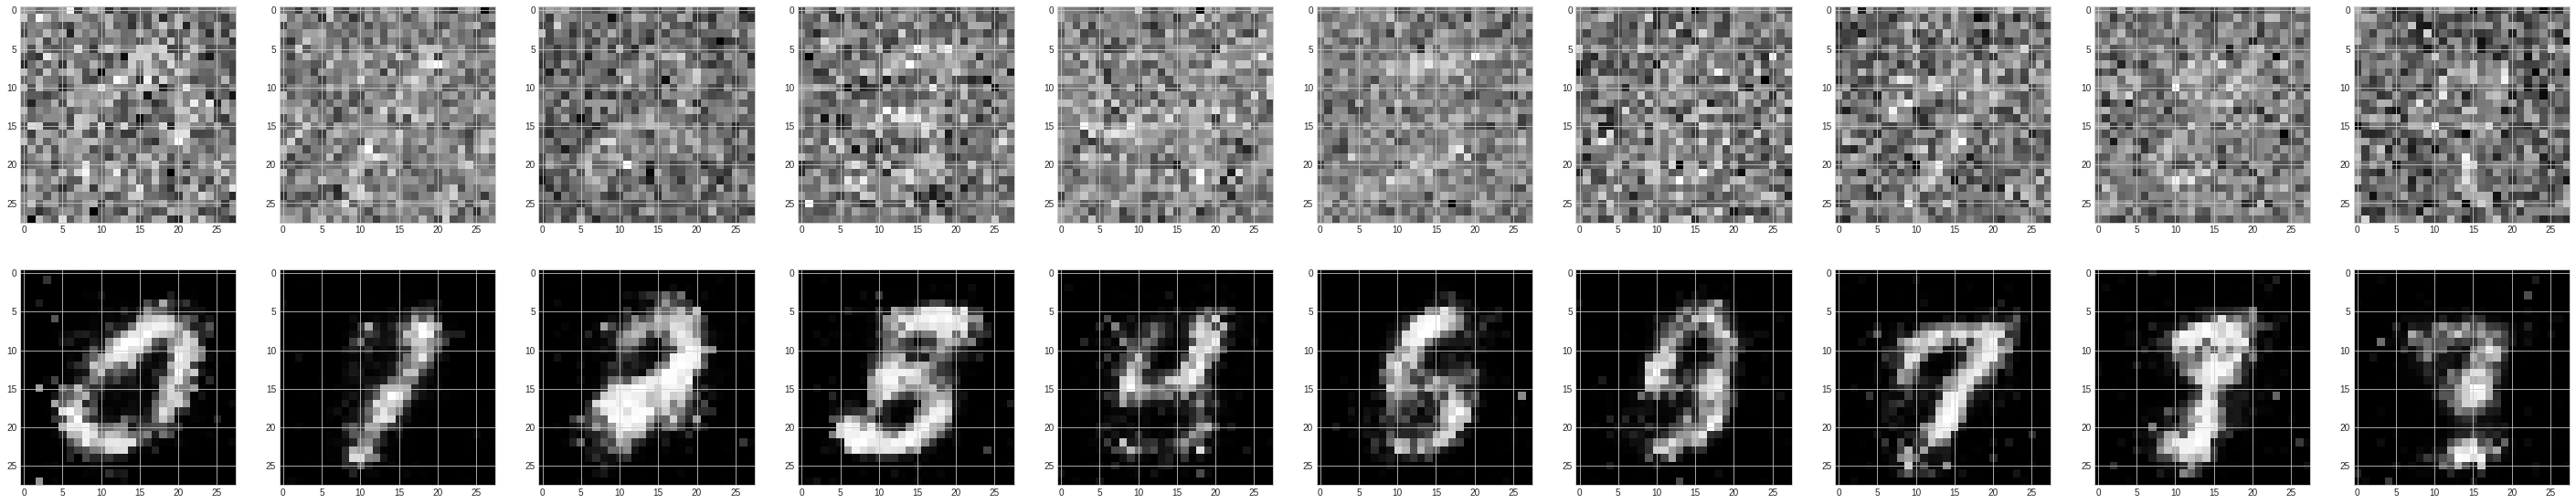

In [ ]:
noise = 1.5
X_train_noise = add_noise(X_train,p=noise)
X_test_noise = add_noise(X_test,p=noise) 





couche_lin = Linear(X_train.shape[1], 100)
couche_lin2 = Linear(100, 144)
couche_lin3 = Linear(144, 100)
couche_lin3._parameters = couche_lin2._parameters.T
couche_lin4 = Linear(100, X_train.shape[1])
couche_lin4._parameters = couche_lin._parameters.T

#cross entropie binaire comme cout 
loss = BCELoss()
#notre encodeur et decodeur
Encodeur = [couche_lin,TanH(),couche_lin2,TanH()]
Decodeur = [couche_lin3,TanH(),couche_lin4,Sigmoid()]
#le reseau
reseau = Sequentiel(Encodeur + Decodeur)

so = Optim(reseau,loss,eps=1e-4)
so.SGD(X_train_noise ,X_train_noise ,50,100,earlystop=50)

print("done")

plot_rec(X_test_noise,so._net)





### Test TSNE et clustering

#### Kmeans + TSNE

In [ ]:
#For standardising the dat
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

X_train,y_train,X_test,y_test = my_train_test_split(10000,1000)
standardized_data = StandardScaler().fit_transform(X_train)

tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(X_train)
kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4,random_state=0)
km = kmeans.fit(X_train)


No handles with labels found to put in legend.


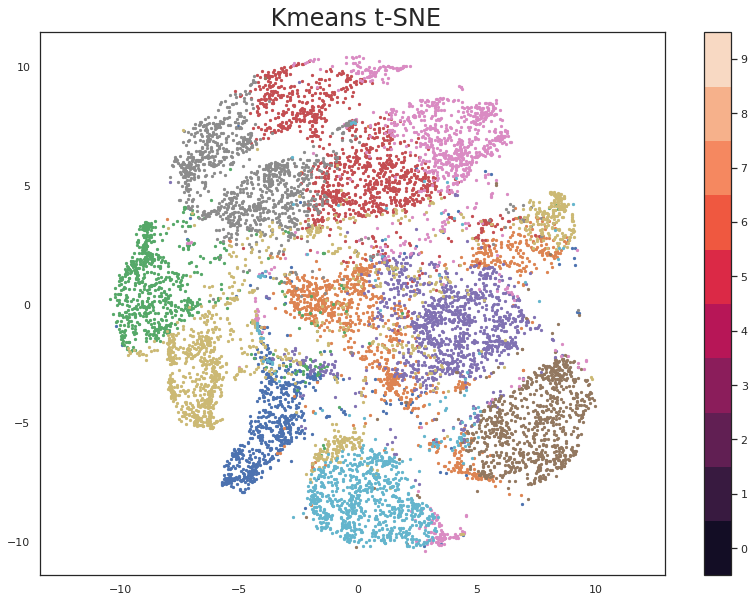

In [ ]:
u_labels = np.unique(km.labels_)
 
#plotting the results:
 
for i in u_labels:
    mask=km.labels_==i
    plt.scatter(tsne[mask][:, 0] , tsne[mask][:, 1]  ,s= 5,cmap='Spectral')
plt.legend()
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title(' Kmeans t-SNE', fontsize=24)
plt.show()


In [ ]:
def perf_clustering(X, y):

    kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4,random_state=0)
    pred = kmeans.fit_predict(X)
    
    eval_metrics = [metrics.homogeneity_score,metrics.completeness_score,metrics.v_measure_score]
    scores = [met(y,pred) for met in eval_metrics]
    
    print("homo score:", scores[0])
    print("complet socre :", scores[1])
    print("v_measure score :", scores[2])
  
    return scores
perf_clustering(X_train,y_train)

homo score: 0.4770733916244317
complet socre : 0.48073164500746735
v_measure score : 0.47889553212496977


[0.4770733916244317, 0.48073164500746735, 0.47889553212496977]

#### TSNE

Text(0.5, 1.0, ' t-SNE')

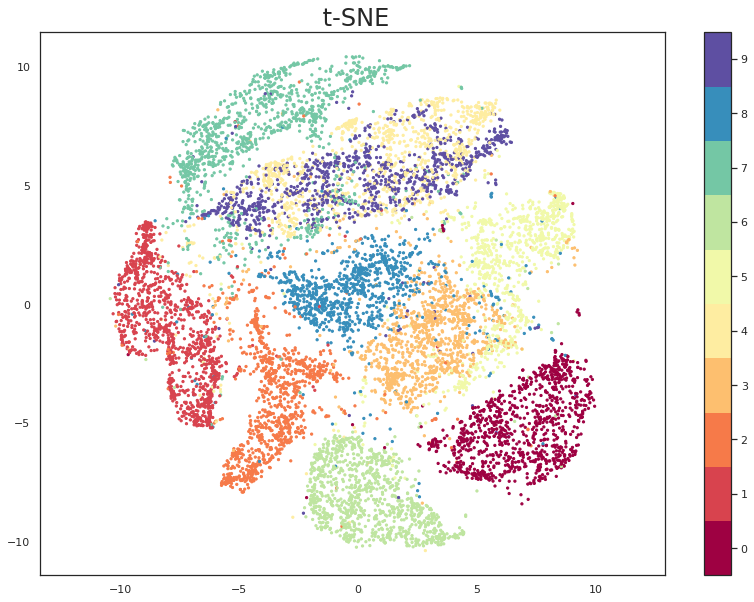

In [ ]:
#tsne seulement
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5,c= y_train,cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title(' t-SNE', fontsize=24)

#### Reconsturction

Text(0.5, 1.0, ' t-SNE')

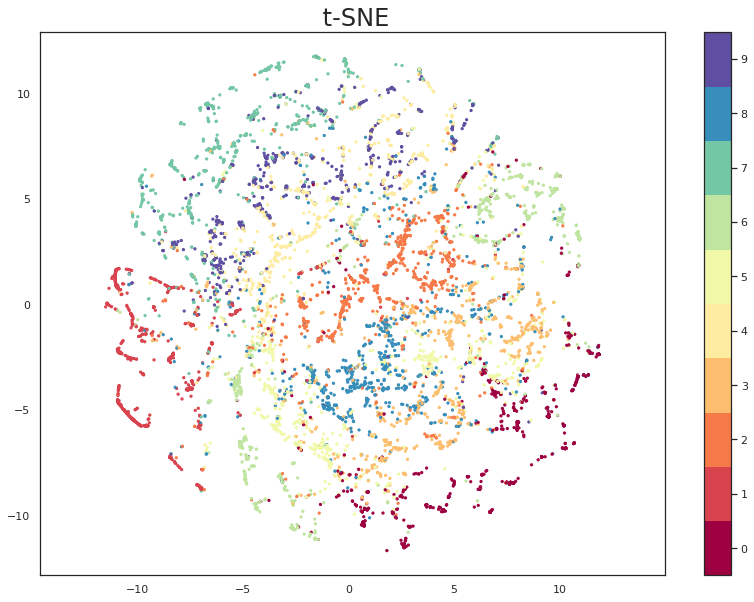

In [ ]:
couche_lin = Linear(X_train.shape[1], 100)
couche_lin2 = Linear(100, 144)
couche_lin3 = Linear(144, 100)
couche_lin3._parameters = couche_lin2._parameters.T
couche_lin4 = Linear(100, X_train.shape[1])
couche_lin4._parameters = couche_lin._parameters.T
def encodeur():
  
  return [couche_lin,TanH(),couche_lin2,TanH()]
def decodeur():
  return  [couche_lin3,TanH(),couche_lin4,Sigmoid()]
#cross entropie binaire comme cout 
loss = BCELoss()
#notre encodeur et decodeur
Encodeur =encodeur()
Decodeur = decodeur()
#le reseau
reseau = Sequentiel(Encodeur + Decodeur)

so = Optim(reseau,loss,eps=1e-4)
so.SGD(X_train,X_train,100,100,earlystop=50)

x_pred = so._net.predict(X_train)
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_pred)
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5,c= y_train,cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title(' t-SNE', fontsize=24)


No handles with labels found to put in legend.


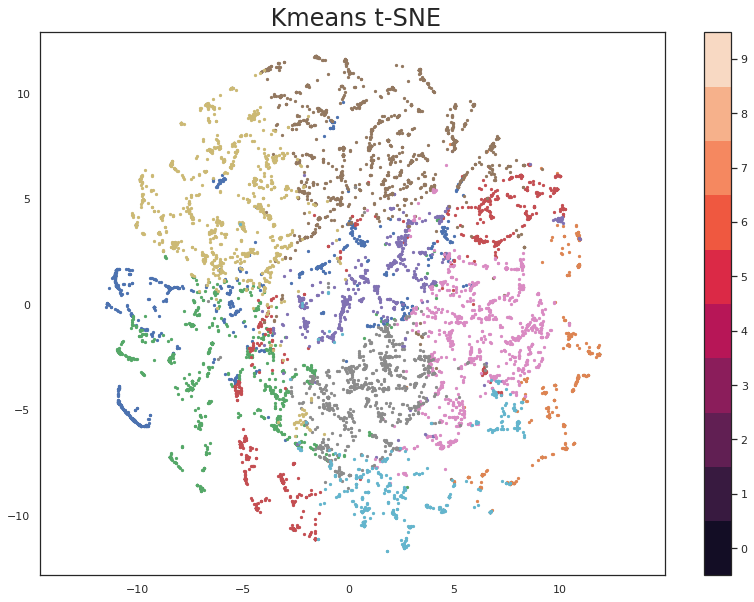

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4,random_state=0)
km = kmeans.fit(x_pred)
u_labels = np.unique(km.labels_)
 
#plotting the results:
 
for i in u_labels:
    mask=km.labels_==i
    plt.scatter(tsne[mask][:, 0] , tsne[mask][:, 1] ,s= 5,cmap='Spectral')
plt.legend()
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title(' Kmeans t-SNE', fontsize=24)
plt.show()

# Test Convolutions

### Données synthetiques

In [ ]:
def pred(x):
    #retourner la meuilleur classe
    return np.argmax(x,axis=1)

datax = np.random.randn(20, 10)
datay = np.random.choice([-1, 1], 20, replace=True)

linear = Linear(20, 1)
conv1D = Conv1D(k_size=3, chan_in=1, chan_out=5, stride=1)
maxpool1D = MaxPool1D(k_size=2,stride=2) 
softmax = Softmax()
loss = CElogSoftMax()
flatten = Flatten()



net = Sequentiel([conv1D,
                  maxpool1D,
                  flatten,
                  linear,
                  softmax],labels=pred)
modele = Optim(net,loss,eps=1e-4)

modele.SGD(datax.reshape(20,10,-1),datay.reshape(-1,1),10,10,earlystop=60)

([1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574,
  1.0000367872674574],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Données USPS

#### Conv1D

In [ ]:
def encod_onehot(y):
    onehot = np.zeros((y.size,y.max()+1));
    onehot[np.arange(y.size),y]=1
    return onehot

# Load Data From USPS , directement pris depuis TME4
uspsdatatrain = "/gdrive/MyDrive/Sorbonne/ML/projet/data/USPS_train.txt"
uspsdatatest = "/gdrive/MyDrive/Sorbonne/ML/projet/data/USPS_test.txt"
alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:5000],alltrainy[:5000]
alltestx, alltesty = alltestx[:5000],alltesty[:5000]
# taille couche
input = len(alltrainx[0])
out = len(np.unique(alltesty))
alltrainy = encod_onehot(alltrainy)
alltesty= encod_onehot(alltesty)
alltrainx = alltrainx.reshape(alltrainx.shape[0], alltrainx.shape[1], 1)
alltestx = alltestx.reshape(alltestx.shape[0], alltestx.shape[1], 1)

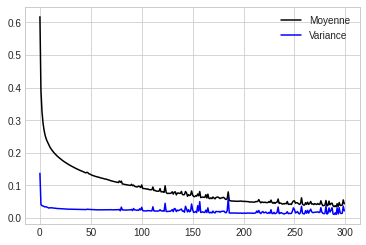

In [ ]:
def pred(x):
    #retourner la meuilleur classe
    return np.argmax(x,axis=1)

score = []
iteration = 300
gradient_step = 1e-4
batch_size = 100
net = Sequentiel([Conv1D(3, 1, 32, stride=1),
                      MaxPool1D(2, 2),
                      Flatten(),
                      Linear(4064, 100),
                      ReLU(),
                      Linear(100, 10),
                      Softmax()
                      ],labels=pred)
optim1 = Optim(net, CELoss(), 1e-3)        

moyenne,variance= optim1.SGD(alltrainx, alltrainy,batch_size,iteration,200)

plt.figure()
plt.plot(moyenne,'black')
plt.plot(variance,'blue')
plt.legend(('Moyenne', 'Variance'))
plt.show()


In [ ]:

alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:5000],alltrainy[:5000]
alltestx, alltesty = alltestx[:5000],alltesty[:5000]
alltrainx = alltrainx.reshape(alltrainx.shape[0], alltrainx.shape[1], 1)
alltestx = alltestx.reshape(alltestx.shape[0], alltestx.shape[1], 1)

predict = optim1._net.predict(alltrainx)
print((np.where(predict == alltrainy, 1, 0)).mean() )

#### Conv2D

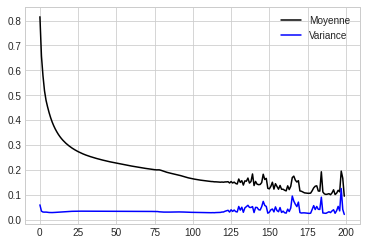

In [ ]:
#taille couche
def encod_onehot(y):
    onehot = np.zeros((y.size,y.max()+1));
    onehot[np.arange(y.size),y]=1
    return onehot

# Load Data From USPS , directement pris depuis TME4
uspsdatatrain = "/gdrive/MyDrive/Sorbonne/ML/projet/data/USPS_train.txt"
uspsdatatest = "/gdrive/MyDrive/Sorbonne/ML/projet/data/USPS_test.txt"
alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)
alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:1000],alltrainy[:1000]
alltestx, alltesty = alltestx[:1000],alltesty[:1000]

alltrainy = encod_onehot(alltrainy)
alltesty= encod_onehot(alltesty)

alltrainx=alltrainx.reshape(alltrainx.shape[0],16,16,1)
alltestx=alltestx.reshape(alltestx.shape[0],16,16,1)

iteration = 200
gradient_step = 1e-2
batch_size = 70


net = Sequentiel([Conv2D(3, 1, 32, stride=1),
                      MaxPool2D(2, 2),
                      Flatten(),
                      Linear(1568,100),
                      ReLU(),
                      Linear(100, 10),
                      Softmax()
                      ],labels=pred)
optim = Optim(net, CELoss(), 1e-3)        

moyenne,variance= optim.SGD(alltrainx, alltrainy,batch_size,iteration,200)

plt.figure()
plt.plot(moyenne,'black')
plt.plot(variance,'blue')
plt.legend(('Moyenne', 'Variance'))
plt.show()

alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:1000],alltrainy[:1000]
alltestx, alltesty = alltestx[:1000],alltesty[:1000]

alltrainx=alltrainx.reshape(alltrainx.shape[0],16,16,1)
alltestx=alltestx.reshape(alltestx.shape[0],16,16,1)



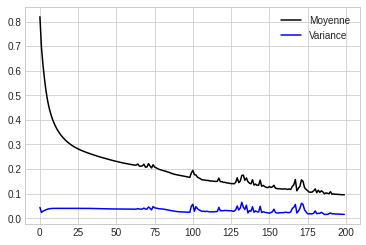

In [ ]:

plt.figure()
plt.plot(moyenne,'black')
plt.plot(variance,'blue')
plt.legend(('Moyenne', 'Variance'))
plt.show()


In [ ]:
alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:1000],alltrainy[:1000]
alltestx, alltesty = alltestx[:1000],alltesty[:1000]

alltrainx=alltrainx.reshape(alltrainx.shape[0],16,16,1)
alltestx=alltestx.reshape(alltestx.shape[0],16,16,1)

In [ ]:
predict = optim._net.predict(alltrainx)
print((np.where(predict == alltrainy, 1, 0)).mean() )


0.949
